In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
from collections import Counter
np.set_printoptions(suppress=True)

/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [2]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
#data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')
S = 35
dat = np.zeros(S + 1)
out = Counter(data['count'].values)
for k,v in out.items():
    dat[k] = v
V = len(workers)
print(S, V)

35 46145


In [80]:
def logp_capture(alpha, beta, p, mix, U, D, S):
    def ll_capture_f(ni):
        # params
        
        # useful vars
        i = tt.arange(S + 1)
        
        # At least one capture
        # binomln(n, k) + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
        
        #binomln
        #Li =  tt.gammaln(S + 1) - tt.gammaln(i + 1) - tt.gammaln(S - i + 1)
        
        # betaln(i + alpha, n - i + beta)
        # betaln = gammaln(x) + gammaln(y) - gammaln(x + y)
        
        LiBin = tt.log(mix) + i * tt.log(p) + (S-i) * tt.log(1-p)
        LiBin = tt.exp(LiBin)
        
        
        LiBB = tt.log(1-mix) + tt.gammaln(i + alpha) + tt.gammaln(S - i + beta) - tt.gammaln(S + alpha + beta)
        LiBB += tt.gammaln(alpha + beta) - tt.gammaln(alpha) - tt.gammaln(beta)
        LiBB = tt.exp(LiBB)
        
        Li = tt.log(LiBin + LiBB)
        
        # No captures
        #(betaln(alpha, S + beta) - betaln(alpha, beta))
        
        L0Bin = tt.log(mix) + S * tt.log(1-p)
        L0Bin = tt.exp(L0Bin)
        
        L0BB = tt.log(1-mix) + tt.gammaln(S + beta) - tt.gammaln(S + alpha + beta) + tt.gammaln(alpha + beta) - tt.gammaln(beta)
        L0BB = tt.exp(L0BB)
        
        L0 = tt.log(L0Bin + L0BB)
        
        
        # Likelihood
        obj1 = tt.gammaln(D+U+1) - tt.gammaln(U+1) #- tt.sum(tt.gammaln(ni+1))
        obj2 = tt.sum(tt.mul(ni, Li))
        obj3 = U * L0
        obj = obj1 + obj2 + obj3 
        return obj
    return ll_capture_f

In [95]:
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=10000, upper=10000000)
    a = pm.Uniform('alpha', .5, 10.)
    b = pm.Uniform('beta', 0., 100.)
    p = pm.Uniform('p', 0., 1.)
    mix = pm.Uniform('mix', 0., 1.)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(a, b, p, mix, U, V, S), observed=dat)

In [96]:
with model:
  posterior = pm.sample(10000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, p, beta, alpha, Unseen]
Sampling 4 chains: 100%|██████████| 42000/42000 [11:53<00:00, 13.62draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9848136333491575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9713766298134524, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9477133970690375, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


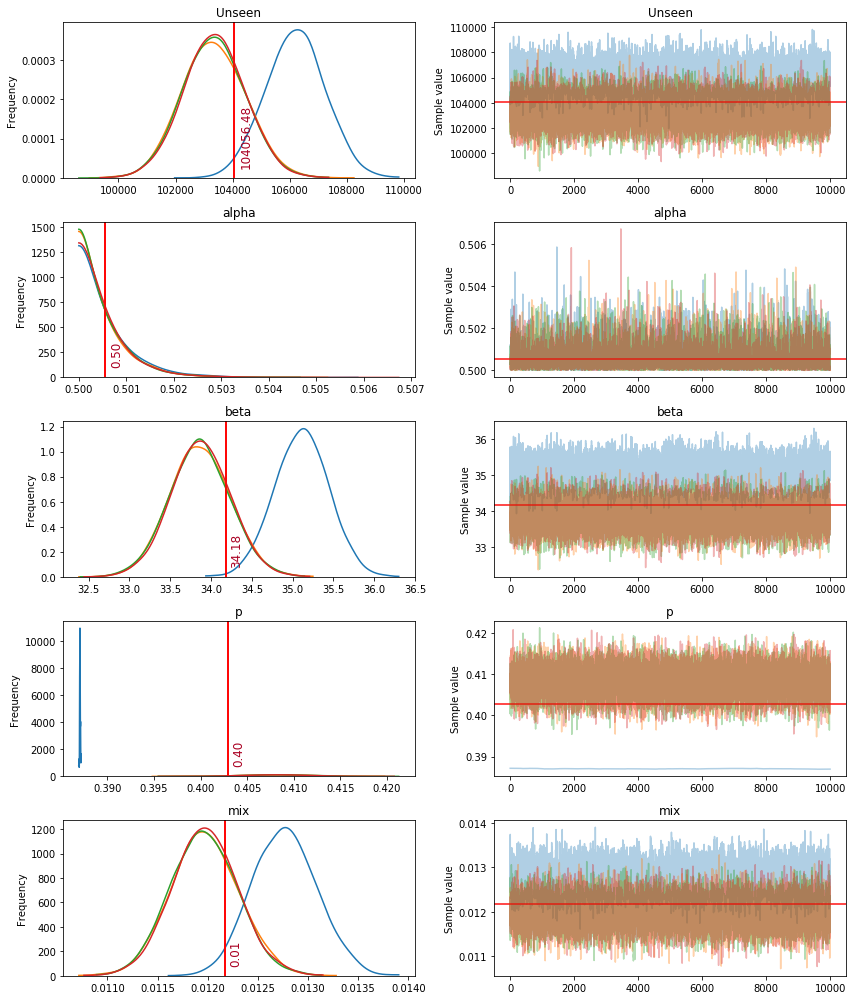

In [97]:
plot_traces(posterior)

In [35]:
i = tt.arange(S + 1)

In [37]:
i.eval()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])